In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [3]:

#nltk.corpus.conll2002.fileids()
segmented_corpus_dic = []
test_corpus = []
new_sentence_1 = []
new_sentence_2 = []

def read_in_corpus(text_list,dic):
    new_sentence = []
    for string in text_list:
        tup1 = ()  
        array = string.split(' ')
        if len(array)>2:
            if array[2] == 'I':
                if new_sentence:
                    dic.append(new_sentence)
                new_sentence = []
            tupl = (array[0],array[1],array[2])
            #print tupl
            new_sentence.append(tupl)

with open("Sheffield_Converter/txt_files/ru008_000c.txt") as fl:
    lines = fl.read().splitlines()
    read_in_corpus(lines,segmented_corpus_dic) 
    print segmSented_corpus_dic

with open("Sheffield_Converter/txt_files/zh012_006c.txt") as ft:
    lines = ft.read().splitlines()
    read_in_corpus(lines,test_corpus)
    #print test_corpus

NameError: name 'segmSented_corpus_dic' is not defined

In [8]:
%%time
train_sents = list(segmented_corpus_dic)
test_sents = list(test_corpus)
print len(train_sents)

4164
CPU times: user 761 µs, sys: 602 µs, total: 1.36 ms
Wall time: 913 µs


In [5]:
#print "training data set"
print type(train_sents[3])
#print "test data set"
print test_sents[1][0]
print type(test_sents[1][0][0])

<type 'list'>
('\xe4\xba\x8c', 'number', 'I')
<type 'str'>


## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [6]:
def word2features(sent, i):
    word = sent[i][0][0]
    postag = sent[i][0][1]
    
    features = {
        'bias': 1.0,
        #'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        #'word.isupper()': word.isupper(),
        #'word.istitle()': word.istitle(),
        #'word.isdigit()': word.isdigit(),
        #'postag': postag,
        #'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0][0]
        postag1 = sent[i-1][0][1]
        features.update({
        #    '-1:word.lower()': word1.lower(),
        #    '-1:word.istitle()': word1.istitle(),
        #    '-1:word.isupper()': word1.isupper(),
        #    '-1:postag': postag1,
        #    '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0][0]
        postag1 = sent[i+1][0][1]
        features.update({
        #    '+1:word.lower()': word1.lower(),
        #    '+1:word.istitle()': word1.istitle(),
        #    '+1:word.isupper()': word1.isupper(),
        #    '+1:postag': postag1,
        #    '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [7]:
sent2features(train_sents)[1000]

{'bias': 1.0, 'word[-2:]': '\x80\x95', 'word[-3:]': '\xe6\x80\x95'}

Extract features from the data:

In [8]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]


CPU times: user 45.7 ms, sys: 10.2 ms, total: 56 ms
Wall time: 120 ms


## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [9]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 122 ms, sys: 6.74 ms, total: 129 ms
Wall time: 141 ms


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [10]:
labels = list(crf.classes_)
#labels.remove('O')
labels

['I', 'N']

In [12]:
#print X_test
#print X_test
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)


1.0

Inspect per-class results in more detail:

In [13]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          I      1.000     1.000     1.000      3278
          N      1.000     1.000     1.000      1008

avg / total      1.000     1.000     1.000      4286



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best result:

In [14]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

('best params:', {'c2': 0.038992464190793379, 'c1': 0.33956053078942694})
('best CV score:', 1.0)
model size: 0.00M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

/Users/Elliscope/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/Elliscope/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/Elliscope/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Dark blue => 1.0, dark red => 1.0


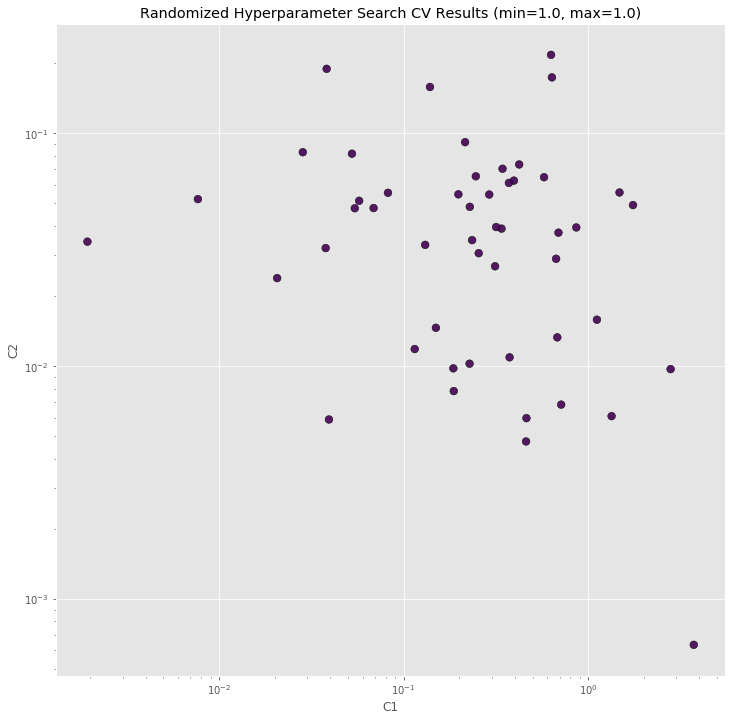

In [16]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [17]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          I      1.000     1.000     1.000      3278
          N      1.000     1.000     1.000      1008

avg / total      1.000     1.000     1.000      4286



## Let's check what classifier learned

In [18]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I      -> N       3.556660
N      -> N       3.417624
N      -> I       -2.869666
I      -> I       -4.096910

Top unlikely transitions:
I      -> N       3.556660
N      -> N       3.417624
N      -> I       -2.869666
I      -> I       -4.096910


We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [19]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
8.304193 I        BOS

Top negative:
8.304193 I        BOS




Some observations:

   * **9.385823 B-ORG word.lower():psoe-progresistas** - the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
   * **4.636151 I-LOC -1:word.lower():calle:** "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
   * **-5.632036 O word.isupper()**, **-8.215073 O word.istitle()** : UPPERCASED or TitleCased words are likely entities of some kind;
   * **-2.097561 O postag:NP** - proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

What to do next

    * Load 'testa' Spanish data.
    * Use it to develop better features and to find best model parameters.
    * Apply the model to 'testb' data again.

The model in this notebook is just a starting point; you certainly can do better!

